# Tiling the bathroom

_Combinatorial Optimization course, FEE CTU in Prague. Created by [Industrial Informatics Department](http://industrialinformatics.fel.cvut.cz)._

## Motivation

You accidentally dropped a bowling ball in your bathroom, which cracked a significant part of the floor. You successfully removed the debris, but now you must fill the resulting rectangular hole with new tiles. However, the tiles are pretty costly, so you asked the neighbors whether they have any spares. Finally, you acquired several different rectangular tiles whose area is equal to the area of the hole. Are you able to repair the floor?

## Input

You are given the following:

* Rectangle hole in your bathroom of dimensions $A_x,A_y$
* $n$ different square tiles described by their size $a_i$

For the experiments, you may use the following instance:

In [1]:
!pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
A_x, A_y = 33, 32
a = [1, 4, 7, 8, 9, 10, 14, 15, 18]
# A_x, A_y = 4, 4
# a = [2, 2, 1, 1, 1, 1, 2]
n = len(a)

A_sq = A_x * A_y
tiles_sq = sum(a[i] * a[i] for i in range(n))
A_sq, tiles_sq

(1056, 1056)

## Output

You should find a positions of the bottom-left corners of the tiles so you fill the entire hole in your bathroom.

## Exercise

Implement the ILP model of the problem.

In [3]:
# RELATIVE ENCODING

import gurobipy as g  # import Gurobi module
from itertools import combinations

# model --------------------------------------------------
m = g.Model()

# bottom left rectangles' coordinates
xs = m.addVars(n, lb=0, ub=A_sq, vtype=g.GRB.INTEGER)
ys = m.addVars(n, lb=0, ub=A_sq, vtype=g.GRB.INTEGER)

# relative position variables
rp_x = m.addVars(n, n, vtype=g.GRB.BINARY)
rp_y = m.addVars(n, n, vtype=g.GRB.BINARY)

# This could be embedded into variable creation (0 skipped, because already ensured by lb)
for i in range(n):
    m.addConstr(xs[i] + a[i] <= A_x)
    m.addConstr(ys[i] + a[i] <= A_y)

# Solve relative placement (pairs) - so we do not get overlap
for i, j in combinations([i for i in range(n)], 2):

    # first left to second
    m.addConstr(xs[i] + a[i] <= xs[j] + A_sq * (1 - rp_x[i, j]))
    # second left to first
    m.addConstr(xs[j] + a[j] <= xs[i] + A_sq * (1 - rp_x[j, i]))
    # first under the second
    m.addConstr(ys[i] + a[i] <= ys[j] + A_sq * (1 - rp_y[i, j]))
    # second under the first
    m.addConstr(ys[j] + a[j] <= ys[i] + A_sq * (1 - rp_y[j, i]))


    # at least one relative position constraint needs to hold to ensure there is no overlap
    m.addConstr(rp_x[i, j] + rp_x[j, i] + rp_y[i, j] + rp_y[j, i] >= 1)

m.optimize()

# Parse for image
positions = [(0, 0) for i in range(n)]
for i in range(n):
    positions[i] = (round(xs[i].x), round(ys[i].x))

Set parameter Username
Set parameter LicenseID to value 2629039
Academic license - for non-commercial use only - expires 2026-02-27
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 198 rows, 180 columns and 594 nonzeros
Model fingerprint: 0x80d70b61
Variable types: 0 continuous, 180 integer (162 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
Presolve removed 23 rows and 23 columns
Presolve time: 0.00s
Presolved: 175 rows, 157 columns, 560 nonzeros
Variable types: 0 continuous, 157 integer (141 binary)

Root relaxation: objective 0.000000e+00, 62 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

In [4]:
# POSITION ENCODING

import gurobipy as g  # import Gurobi module

# model --------------------------------------------------
m = g.Model()

xs = m.addVars(A_x, A_y, n, vtype=g.GRB.BINARY)
ys = m.addVars(A_x, A_y, n, vtype=g.GRB.BINARY)

m.addConstr(A_sq == tiles_sq) # since this model tries to fill each tile, we need to check whether it is possible (tiles_sq >= A_sq) and also check that there is no overlap if each tile is filled (tiles_sq <= A_sq)

m.addConstrs(xs.sum("*", "*", i) == 1 for i in range(n)) # each bottom-left corner of some tile is placed somewhere
m.addConstrs(xs.sum(x, y, "*") <= 1 for x in range(A_x) for y in range(A_y)) # each position has at most one bottom-left corner of some tile

for x in range(A_x):
    for y in range(A_y):
        for i in range(n):
            m.addConstr(ys[x, y, i] == sum(xs[x_start, y_start, i] for x_start in range(max(0, x - (a[i] - 1)), x + 1) for y_start in range(max(0, y - (a[i] - 1)), y + 1)))  # connectivness and completeteness of tile placement

for x in range(A_x):
    for y in range(A_y):
        m.addConstr(ys.sum(x, y, "*") == 1) # each position is occupied by exactly one tile

m.optimize()

# solution -----------------------------------------------
positions = [(0,0) for i in range(n)]
for x in range(A_x):
    for y in range(A_y):
        for i in range(n):
            if xs[x, y, i].X > .5:
                assert positions[i] == (0, 0)
                positions[i] = (x, y)
positions

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 11626 rows, 19008 columns and 760269 nonzeros
Model fingerprint: 0xad859b3d
Variable types: 0 continuous, 19008 integer (19008 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 8282 rows and 8399 columns (presolve time = 5s)...
Presolve removed 8282 rows and 8399 columns
Presolve time: 5.06s
Presolved: 3344 rows, 10609 columns, 470669 nonzeros
Variable types: 0 continuous, 10609 integer (10609 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+

[(8, 22),
 (15, 18),
 (8, 15),
 (0, 15),
 (0, 23),
 (9, 22),
 (19, 18),
 (0, 0),
 (15, 0)]

## Visualisation



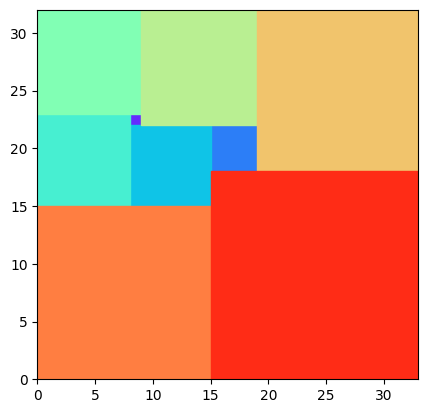

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm

fig, ax = plt.subplots()

# ax.set_xlim((0, Ax.x))  # Useful for optimization case
# ax.set_ylim((0, Ay.x))
ax.set_xlim((0, A_x))
ax.set_ylim((0, A_y))
ax.set_aspect("equal")

# positions in form of (x, y)
for i in range(n):
    ax.add_patch(Rectangle(positions[i], a[i], a[i], color=cm.rainbow((i + 0.5)/n)))

plt.show()